# Feature Selection & Engineering


In [1]:

# Step 1: Load the Cleaned Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

# Load the preprocessed dataset
csv_path = 'cleaned_student_depression.csv'  # Ensure this matches your saved file path
df = pd.read_csv(csv_path)



In [2]:
# Step 2: Additional Feature Engineering
# Since preprocessing already encoded and scaled, add new features here

# 2.1: Interaction Features
# Create interaction between key predictors 
df['Academic_Financial_Interaction'] = df['Academic Pressure'] * df['Financial Stress']

# 2.2: Binned Features
# Bin Age into categories based on EDA insights
age_bins = [0, 18, 25, 35, np.inf]
age_labels = ['Teen', 'Young Adult', 'Adult', 'Senior']
df['Age_Group'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels)
le = LabelEncoder()
df['Age_Group'] = le.fit_transform(df['Age_Group'].astype(str))

# 2.3: Aggregate Sleep and Work/Study Hours
df['Total_Stress_Hours'] = df['Work/Study Hours'] + (5 - df['Sleep Duration'])  # Inverse sleep for stress

# 2.4: Drop Low-Variance Features (based on EDA)
drop_cols = ['City', 'Profession', 'Work Pressure', 'Job Satisfaction']  # From EDA recommendations
df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)



In [3]:
# Step 3: Prepare Data for Feature Selection
# Assume 'Depression' is the target column
X = df.drop(columns=['Depression', 'id'])  # Drop target and irrelevant 'id'
y = df['Depression']

# Encode any new categorical features (e.g., Age_Group)
for col in X.select_dtypes(include=['object']).columns:
    X[col] = le.fit_transform(X[col].astype(str))

# Split data for model-based selection (no need to re-scale as preprocessing handled it)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



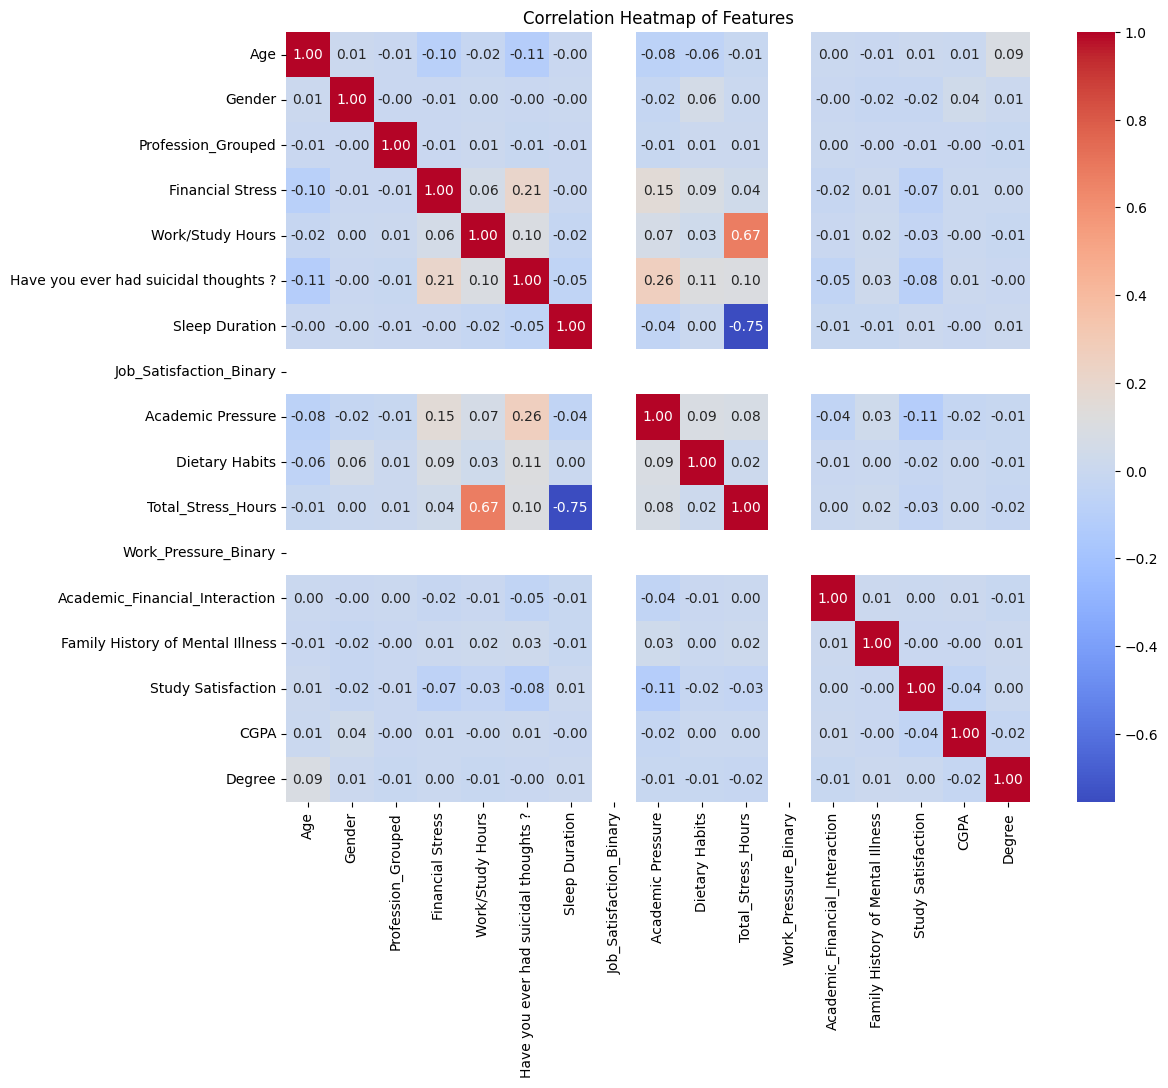

Dropped highly correlated features: set()
Univariate Selection - Top Features:
 ['Age', 'Financial Stress', 'Work/Study Hours', 'Have you ever had suicidal thoughts ?', 'Sleep Duration', 'Academic Pressure', 'Dietary Habits', 'Total_Stress_Hours', 'Academic_Financial_Interaction', 'Study Satisfaction']
Mutual Information - Top Features:
 ['Age', 'Financial Stress', 'Work/Study Hours', 'Have you ever had suicidal thoughts ?', 'Academic Pressure', 'Dietary Habits', 'Total_Stress_Hours', 'Academic_Financial_Interaction', 'Study Satisfaction', 'Degree']
Random Forest Feature Importances:
                                   Feature  Importance
5   Have you ever had suicidal thoughts ?    0.222228
8                       Academic Pressure    0.130229
15                                   CGPA    0.087799
12         Academic_Financial_Interaction    0.086122
0                                     Age    0.085384
3                        Financial Stress    0.071379
10                     Total_S

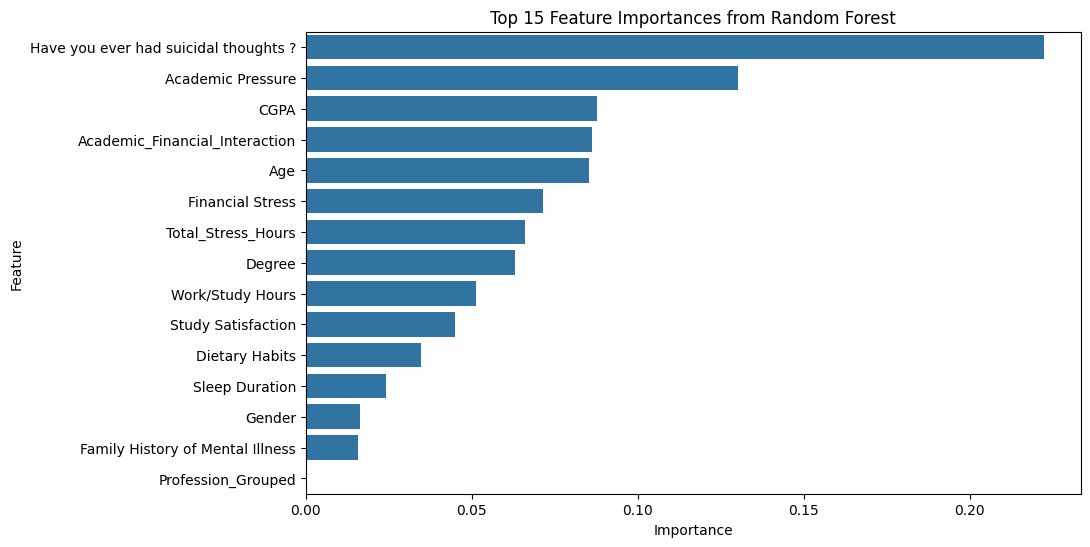

Selected features from RF (importance > 0.01): ['Have you ever had suicidal thoughts ?', 'Academic Pressure', 'CGPA', 'Academic_Financial_Interaction', 'Age', 'Financial Stress', 'Total_Stress_Hours', 'Degree', 'Work/Study Hours', 'Study Satisfaction', 'Dietary Habits', 'Sleep Duration', 'Gender', 'Family History of Mental Illness']


In [7]:
# Step 4: Feature Selection Techniques

# 4.1: Correlation Analysis
plt.figure(figsize=(12, 10))
corr_matrix = X.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Features')
plt.show()

# Drop highly correlated features (threshold > 0.8)
high_corr_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr_features.add(corr_matrix.columns[i])
X = X.drop(columns=high_corr_features, inplace=False)
X_train = X_train.drop(columns=[col for col in high_corr_features if col in X_train.columns], inplace=False)
X_test = X_test.drop(columns=[col for col in high_corr_features if col in X_test.columns], inplace=False)
print(f"Dropped highly correlated features: {high_corr_features}")

# 4.2: Univariate Selection (ANOVA F-test)
selector = SelectKBest(score_func=f_classif, k=10)  # Select top 10 features
selector.fit(X_train, y_train)
scores = pd.DataFrame({'Feature': X_train.columns, 'F-Score': selector.scores_})

selected_features = X_train.columns[selector.get_support()].tolist()
print("Univariate Selection - Top Features:\n", selected_features)

# 4.3: Mutual Information
mi_selector = SelectKBest(score_func=mutual_info_classif, k=10)
mi_selector.fit(X_train, y_train)
mi_scores = pd.DataFrame({'Feature': X_train.columns, 'MI Score': mi_selector.scores_})
mi_selected_features = X_train.columns[mi_selector.get_support()].tolist()
print("Mutual Information - Top Features:\n", mi_selected_features)
# Ensure the columns in X, X_train, and X_test are aligned for later steps
common_cols = list(set(X.columns) & set(X_train.columns) & set(X_test.columns))
X = X[common_cols]
X_train = X_train[common_cols]
X_test = X_test[common_cols]
# 4.4: Model-Based Selection (Random Forest)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
importances = importances.sort_values(by='Importance', ascending=False)
print("Random Forest Feature Importances:\n", importances.head(10))

# Plot top 15 feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances.head(15))
plt.title('Top 15 Feature Importances from Random Forest')
plt.show()

# Select features with importance > threshold
threshold = 0.01
selected_features_rf = importances[importances['Importance'] > threshold]['Feature'].tolist()
print(f"Selected features from RF (importance > {threshold}): {selected_features_rf}")



In [8]:
# Step 5: final Feature Set
# Combine selections (e.g., intersection of RF and Univariate for robustness)
final_features = list(set(selected_features_rf) & set(selected_features))
print(f"final selected features: {final_features}")

X_final = X[final_features]



final selected features: ['Age', 'Financial Stress', 'Work/Study Hours', 'Have you ever had suicidal thoughts ?', 'Sleep Duration', 'Academic Pressure', 'Dietary Habits', 'Total_Stress_Hours', 'Study Satisfaction', 'Academic_Financial_Interaction']


In [9]:
# Step 6: Evaluate with a Simple Model
X_train_final, X_test_final = X_train[final_features], X_test[final_features]
rf.fit(X_train_final, y_train)
y_pred = rf.predict(X_test_final)
print("Classification Report with final Features:\n", classification_report(y_test, y_pred))



Classification Report with final Features:
               precision    recall  f1-score   support

           0       0.79      0.77      0.78      2343
           1       0.84      0.85      0.85      3238

    accuracy                           0.82      5581
   macro avg       0.82      0.81      0.81      5581
weighted avg       0.82      0.82      0.82      5581



In [10]:
# Step 7: Save Engineered and Selected Data
df_final = pd.concat([X_final, df[['Depression', 'id']]], axis=1)
df_final.to_csv('final_features_student_depression.csv', index=False)
print("final features saved to 'final_features_student_depression.csv'")

final features saved to 'final_features_student_depression.csv'


 # Train the model using Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Use your final features and target
X = df_final.drop(columns=['Depression', 'id'])
y = df_final['Depression']

# Split again if needed (if not already split)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# Predict
y_pred = logreg.predict(X_test)

# Evaluate
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.79      0.80      2343
           1       0.85      0.87      0.86      3238

    accuracy                           0.84      5581
   macro avg       0.83      0.83      0.83      5581
weighted avg       0.84      0.84      0.84      5581

Confusion Matrix:
 [[1847  496]
 [ 418 2820]]
Accuracy: 0.8362300662963627
